### To-do:

* restrict background linefit to only beginning and end of line profiles
    * Or do not do the line fit, but instead substract the background early on, even before noralizing to area under the curve, as this is currently biased by the background. more so for low intensity lanes.
* Remove the if statements in the fit plotting rotine. perhaps by using the dataframe? Or by changing the call signature of the single_peak function, to accept a tuple of function params, instead of them individual. Then I can just pass in the params of the current line_profile
* Implement setup_gel() function of Agarose class, which allows setting the lane x axis positions. It should do some autoadjustments of the contrast to make it easier. It should also directly use the lane width and plot the used lane for line profile extraction as a slightly red overlay.
* implement another peak finding algorithm, whichis based on inflection point detection of a spline fitted function?
* Implement a function to autodetect the lane positions, based on summing them up aong the y-axis, followed by a peak detection scheme. Perhaps add another function, which calculates also the optimal lane-width, used for all lanes?
* Setup a new class, which can be used for quantitative gel analysis. E.g. it accepts the used ladder and the applied ladder mass, calculates a calibration curve out of it, and uses this to convert the ntensities of other bands into sample mass.
* Setup that lanes can also be selected by label names, not only by indices
* Enable linear contrast adjustment to percentiles.
* Automatically detectif provided linear contrast adjustment is meant to be percentiles (0-1) or raw intensity values.
* For the EMG function, the fitted mean should not be restricted so tightly to the maxima index, as for strong skewedness, the mean of the EMG is not at it's maxima.

In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.signal import argrelextrema, find_peaks
import matplotlib.pyplot as plt
from skimage import io, exposure
import os
import seaborn as sns
import itertools
import pandas as pd
from scipy.integrate import simps
from scipy.stats import norm

from IPython.display import display
from abc import ABC, abstractmethod

class AgaroseGel:
    def __init__(self, path, labels):
        self.path = path
        self.labels = labels
        
        # Dummy attributes
        
        # Methods
        self.Image = Image(self.path, self.labels)
        
    def show_raw_gel(self):
        self.Image.show_raw_image()
        return
    
    def show_adjusted_images(self, x_label_pos, gamma=0.1, gain=1, intensity_range=(0,6000), img_height_factor=0.009, label_rotation=45):
        self.Image.gamma, self.Image.gain, self.Image.intensity_range = gamma, gain, intensity_range
        self.Image.img_height_factor, self.Image.label_rotation = img_height_factor, label_rotation
        self.Image.x_label_pos = x_label_pos
        self.Image.adjust_img_contrast_non_linear()
        self.Image.adjust_img_contrast_linear()
        #save_fig(fig, collage_file_path, save)
        self.x_label_positions = self.Image.plot_adjusted_gels()
        return
    
    def show_line_profiles(self, select_lanes="all", line_profile_width=None, slice_line_profile_length=(0,-1),
                           fit=None, maxima_threshold=0.001, maxima_prominence=None, plot_fits=False, normalization_type="area"):
        
        self.LineProfiles = LineProfiles(self.Image.gel_image, self.labels, self.x_label_positions,
                                         select_lanes, slice_line_profile_length, normalization_type)
        self.LineProfiles.set_line_profile_width(line_profile_width)
        self.LineProfiles.extract_line_profiles()
        self.LineProfiles.normalize_line_profiles()
        self.LineProfiles.plot_selected_line_profiles()
        
        if fit=="gaussian":
            fit_model = GaussianFitModel
        elif fit == "emg":
            fit_model = EmgFitModel
        else:
            print(f"Invalid fit type")
            return
            
        self.LineFits = LineFits(fit_model, self.LineProfiles.selected_line_profiles_normalized, self.LineProfiles.selected_labels,
                                    maxima_threshold, maxima_prominence)
        self.LineFits.fit()
        self.LineFits.display_dataframe()
        
        if plot_fits == True:
            self.LineFits.plot_fits_and_profiles()


class Image:
    def __init__(self, path, labels):
        # Attributed
        self.path = path
        self.labels = labels
        
        # Dummy attributes
        self.gamma, self.gain, self.intensity_range = 0.1, 1, (0,6000)
        
        # Methods
        self.gel_image = self.read_gel_image()
        self.file_name_without_ext, self.collage_file_path = self.process_path_and_create_file_names_for_saving()
        self.lin_contrast_adjusted = self.adjust_img_contrast_linear()
        self.non_lin_contrast_adjusted = self.adjust_img_contrast_non_linear()
        
    
    @staticmethod
    def cm_to_inch(cm):
        return cm * 0.393701
    
    def show_raw_image(self):
        plt.imshow(self.gel_image, cmap='gray')

    def read_gel_image(self):
        gel_image = io.imread(self.path)
        return gel_image

    def process_path_and_create_file_names_for_saving(self):
        file_name_without_ext = os.path.splitext(os.path.basename(self.path))[0]
        base_path = os.path.dirname(self.path)
        collage_file_name = file_name_without_ext + '_collage.png'
        collage_file_path = os.path.join(base_path, collage_file_name)
        return file_name_without_ext, collage_file_path

    def adjust_img_contrast_non_linear(self):
        img_adjusted_non_linear = exposure.adjust_gamma(self.gel_image, gamma=self.gamma, gain=self.gain)
        return img_adjusted_non_linear

    def adjust_img_contrast_linear(self):
        if self.intensity_range:
            img_adjusted_linear = exposure.rescale_intensity(self.gel_image, in_range=self.intensity_range)
        else:
            img_adjusted_linear = self.gel_image
        return img_adjusted_linear

    def plot_adjusted_gels(self):
        fig_height = self.gel_image.shape[0] * self.img_height_factor
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(self.cm_to_inch(18), fig_height))
        fig.suptitle(self.file_name_without_ext, fontsize=14, y=1)

        ax1.imshow(self.non_lin_contrast_adjusted, cmap='gray')
        ax1.set_title('Non-linear Contrast Adjustment')

        ax2.imshow(self.lin_contrast_adjusted, cmap='gray')
        ax2.set_title('Linear Contrast Adjustment')

        if self.x_label_pos and self.labels:
            left_side, right_side, n = self.x_label_pos
            x_label_positions = np.linspace(left_side, right_side, n)
            ax1.set_xticks(x_label_positions)
            ax2.set_xticks(x_label_positions)
            ax1.set_xticklabels(self.labels, rotation=self.label_rotation)
            ax2.set_xticklabels(self.labels, rotation=self.label_rotation)
            ax1.xaxis.set_ticks_position('top')
            ax2.xaxis.set_ticks_position('top')
        else:
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax2.set_xticks([])
            ax2.set_yticks([])

        y_ticks = np.arange(0, self.gel_image.shape[0], 100)
        ax1.set_yticks(y_ticks)
        ax2.set_yticks(y_ticks)
        ax1.tick_params(axis='both', labelsize=8)
        ax2.tick_params(axis='both', labelsize=8)

        plt.show()

        return x_label_positions

    def save_fig(self, fig, save):
        if save:
            fig.savefig(self.collage_file_path, bbox_inches='tight')

class LineProfiles:
    def __init__(self, gel_image, labels, x_label_positions, select_lanes, slice_line_profile_length, normalization_type):
        self.gel_image = gel_image
        self.labels = labels
        #Dummy attributes
        
        #self.slice_start, self.slice_end = None, None
        self.x_label_positions = x_label_positions
        self.select_lanes = select_lanes
        self.slice_start, self.slice_end = slice_line_profile_length
        self.normalization_type = normalization_type
        

    @staticmethod
    def cm_to_inch(cm):
        return cm * 0.393701

    def extract_line_profiles(self):
        if self.select_lanes == "all":
            self.selected_lanes = self.x_label_positions
            self.selected_labels = self.labels
        else:
            self.selected_lanes = [self.x_label_positions[lane] for lane in self.select_lanes]
            self.selected_labels = [self.labels[lane] for lane in self.select_lanes]
            
        self.selected_line_profiles = []
        for selected_lane in self.selected_lanes:
            line_profile = self.extract_line_profile(selected_lane)
            self.selected_line_profiles.append(line_profile)
            
    def extract_line_profile(self, selected_lane):
        start_x = int(selected_lane - (self.line_profile_width / 2))
        end_x = int(selected_lane + (self.line_profile_width / 2))
        line_profile = np.mean(self.gel_image[:, start_x:end_x], axis=1)
        # cut legth of profiles
        line_profile = line_profile[self.slice_start:self.slice_end]
        return line_profile

    def normalize_line_profiles(self):
        if self.normalization_type == "min_max":
            self.selected_line_profiles_normalized = [self.normalize_line_profile_to_min_max(line_profile,) for line_profile in self.selected_line_profiles]
        elif self.normalization_type == "area":
            self.selected_line_profiles_normalized = [self.normalize_line_profile_to_area(line_profile,) for line_profile in self.selected_line_profiles]

    def normalize_line_profile_to_min_max(self, line_profile):
        min_val = np.min(line_profile)
        max_val = np.max(line_profile)
        return (line_profile - min_val) / (max_val - min_val)
    
    def normalize_line_profile_to_area(self, line_profile):
        area = np.trapz(line_profile)
        return line_profile / area

    
    def set_line_profile_width(self, line_profile_width):
            self.line_profile_width = line_profile_width
            if self.x_label_positions is not None and self.line_profile_width is None:
                n = len(self.x_label_positions)
                self.line_profile_width = int(self.gel_image.shape[1] / (n * 2.5)) #2.5 is heuristic value, and depends on the gelcomb used
                print(f"Used line width: {self.line_profile_width} px, with a gel width of: {self.gel_image.shape[1]} px, and {n} xlabel positions")
                

    def plot_selected_line_profiles(self):
        fig, ax1 = plt.subplots(figsize=(self.cm_to_inch(18), self.cm_to_inch(10)))
        ax2 = ax1.twinx()
        x_axis = range(self.slice_start, self.slice_start + len(self.selected_line_profiles[0]))
        for lane_id, _ in enumerate(self.selected_line_profiles_normalized):
            ax1.plot(x_axis, self.selected_line_profiles_normalized[lane_id], label=self.selected_labels[lane_id])
            # If there is only one profile, plot the raw intensity line profile on the right y-axis with transparent color
            if len(self.selected_line_profiles) == 1:
                ax2.plot(x_axis, self.selected_line_profiles[lane_id], color='none')
                ax2.set(ylabel="raw intensity")
                ax2.yaxis.set_tick_params(labelleft=False)  # Hide the right y-axis labels
            else:
                ax2.axis('off')  # Remove the right y-axis
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax1.set(ylabel="normalized", xlabel="Pixel")

        return fig

class FitModel(ABC):
    def __init__(self):
        self.fitted_peaks = []
        self.fit_df = None

    @abstractmethod
    def peak_function(self, x, *params):
        pass

    @abstractmethod
    def single_peak_function(self, x, *params):
        pass

    @abstractmethod
    def peak_area(self, *params, start, end):
        pass

    @staticmethod
    def linear_background_function(x, slope, intercept):
        return slope * x + intercept

    def multi_peak_function(self, x, *params):
        x = x.astype(np.float64)
        result = np.zeros_like(x)
        for i in range(0, len(params) - 2, self.params_per_peak()):
            result += self.peak_function(x, *params[i:i+self.params_per_peak()])
        result += self.linear_background_function(x, params[-2], params[-1])
        return result

    @abstractmethod
    def params_per_peak(self):
        pass

    @abstractmethod
    def initial_guess(self, max_index, line_profile):
        pass

    def fit(self, normalized_line_profiles, maxima_threshold, maxima_prominence, selected_labels):
        for selected_lane_index, selected_normalized_line_profile in enumerate(normalized_line_profiles):
            maxima_indices = LineFits.find_maxima_of_line_profile(selected_normalized_line_profile, maxima_threshold, maxima_prominence)

            # Initial guess for the parameters
            initial_guess = []
            for max_index in maxima_indices:
                initial_guess.extend(self.initial_guess(max_index, selected_normalized_line_profile))

            # Add initial guesses for the slope and intercept of the linear background
            initial_guess.extend([0, 0])  # Assume a flat background as a starting point

            ## Fit the curve to the line profile data
            
            # seed x-axis for fitting
            x = np.arange(len(selected_normalized_line_profile))

            # Define the lower and upper bounds for the parameters
            lower_bounds = [0] * len(initial_guess)
            upper_bounds = [np.inf] * len(initial_guess)
            # Fix the mean values during fitting to the previously detected maxima +-1 # kinda breaking the emg fitting, as mean does not have to be maxima.
            for i, max_index in enumerate(maxima_indices):
                lower_bounds[i*self.params_per_peak()+1] = max_index -1
                upper_bounds[i*self.params_per_peak()+1] = max_index +1
            bounds = (lower_bounds, upper_bounds)
            print(f"initial_guess: {initial_guess}\nlower_bounds{lower_bounds}\nupper_bounds{upper_bounds}")

            try:
                optimized_parameters, _ = opt.curve_fit(self.multi_peak_function, x, selected_normalized_line_profile, p0=initial_guess, bounds=bounds)
                self.fitted_peaks.append((selected_lane_index, selected_labels[selected_lane_index], optimized_parameters))
            except RuntimeError:
                print(f"Failed to fit curve for line profile {selected_labels[selected_lane_index]}")

    def create_fit_dataframe(self, selected_normalized_line_profiles):
        data = []
        for i, (selected_lane_index, label, params) in enumerate(self.fitted_peaks):
            total_area = 0
            # Calculate the area under each peak
            start = 0
            end = len(selected_normalized_line_profiles[i])
            for j in range(0, len(params) - 2, self.params_per_peak()):  # Exclude the last two parameters for the linear background
                area = self.peak_area(*params[j:j+self.params_per_peak()], start, end)
                total_area += area

            # Calculate the relative area of each peak and create a new row for each peak
            for j in range(0, len(params) - 2, self.params_per_peak()):  # Exclude the last two parameters for the linear background
                area = self.peak_area(*params[j:j+self.params_per_peak()], start, end)
                relative_area = area / total_area
                band_number = j+1
                peak_data = [selected_lane_index, label, band_number, relative_area, *params[j:j+self.params_per_peak()]]
                data.append(peak_data)

        # Create a DataFrame from the data
        columns = ["selected_lane_index", "label", "band_number", "relative_area"] + self.param_labels()
        self.fit_df = pd.DataFrame(data, columns=columns)
        return self.fit_df

    @abstractmethod
    def param_labels(self):
        pass


class GaussianFitModel(FitModel):
    def __init__(self):
        super().__init__()
        self.fit_type = "gaussian"

    def peak_function(self, x, amplitude, mean, stddev):
        return (amplitude * np.exp(-((x - mean) ** 2) / (2 * (stddev ** 2)))).astype(np.float64)

    def single_peak_function(self, x, amplitude, mean, stddev):
        return norm.pdf(x, loc=mean, scale=stddev) * amplitude

    def peak_area(self, amplitude, mean, stddev, start, end):
        x = np.arange(start, end)
        y = self.single_peak_function(x, amplitude, mean, stddev)
        area = simps(y, x)
        return area

    def params_per_peak(self):
        return 3  # amplitude, mean, stddev

    def initial_guess(self, max_index, line_profile):
        return [line_profile[max_index], max_index, 1]  # amplitude, mean, stddev

    def param_labels(self):
        return ["Amplitude", "Mean", "Standard Deviation"]


class EmgFitModel(FitModel):
    def __init__(self):
        super().__init__()
        self.fit_type="emg"

    def peak_function(x, amplitude, mean, stddev, lambda_): # x sign inverted to get left leaning emg
        term1 = (x - mean) / lambda_ + (stddev ** 2) / (2 * lambda_ ** 2)
        term2 = (mean - x) / stddev - stddev / lambda_
        return (amplitude / lambda_ * np.exp(term1) * norm.cdf(term2)).astype(np.float64)

    def single_peak_function(self, x, amplitude, mean, stddev, lambda_):
        return self.peak_function(x, amplitude, mean, stddev, lambda_)

    def peak_area(self, amplitude, mean, stddev, lambda_, start, end):
        x = np.linspace(start, end, 1000)
        y = self.single_peak_function(x, amplitude, mean, stddev, lambda_)
        area = simps(y, x)
        return area

    def params_per_peak(self):
        return 4  # amplitude, mean, stddev, lambda_

    def initial_guess(self, max_index, line_profile):
        return [line_profile[max_index], max_index, 1, 1]

    def param_labels(self):
        return ["Amplitude", "Mean", "Standard Deviation", "Lambda"]

class LineFits:
    def __init__(self, fit_model, selected_normalized_line_profiles, selected_labels, maxima_threshold, maxima_prominence):
        self.selected_normalized_line_profiles = selected_normalized_line_profiles
        self.selected_labels = selected_labels
        self.maxima_threshold = maxima_threshold
        self.maxima_prominence = maxima_prominence
        self.fit_model = fit_model()

    @staticmethod
    def cm_to_inch(cm):
        return cm * 0.393701

    @staticmethod
    def find_maxima_of_line_profile(line_profile, maxima_threshold, prominence, window_length=4):
        maxima_indices, _ = find_peaks(line_profile, height=maxima_threshold, prominence=prominence)
        return maxima_indices

    def fit(self):
        self.fit_model.fit(self.selected_normalized_line_profiles, self.maxima_threshold, self.maxima_prominence, self.selected_labels)
        self.fit_model.create_fit_dataframe(self.selected_normalized_line_profiles)
    
    ## To-do: remove the if statements for the fit model, and change the single_peak functions instead or something.
    def plot_fits_and_profiles(self):
        # Create a figure with two columns and as many rows as there are normalized_line_profiles
        n_profiles = len(self.selected_normalized_line_profiles)
        fig, axs = plt.subplots(n_profiles, 2, figsize=(LineFits.cm_to_inch(18), n_profiles*LineFits.cm_to_inch(7)), sharey='row', squeeze=False)

        for i, (selected_lane_index, selected_label, optimized_parameters) in enumerate(self.fit_model.fitted_peaks):
            x = np.arange(len(self.selected_normalized_line_profiles[selected_lane_index]))

            # Plot the normalized_line_profile in the left subplot
            axs[i, 0].plot(x, self.selected_normalized_line_profiles[selected_lane_index], color='black', alpha=0.5)
            axs[i, 0].set_title(f'Normalized Line Profile - {selected_label}')
            axs[i, 0].set_xlabel('Pixel')
            axs[i, 0].set_ylabel('Intensity normalized to area')

            # Plot the sum of all peaks fitted for this line profile in the left subplot
            axs[i, 0].plot(x, self.fit_model.multi_peak_function(x, *optimized_parameters), color='black', linestyle='dotted')

            # Plot all the peaks fitted for this line profile in the right subplot
            for j in range(0, len(optimized_parameters) - 2, self.fit_model.params_per_peak()):  # Exclude the last two parameters for the linear background
                optimized_parameters_structured = optimized_parameters[j:j+self.fit_model.params_per_peak()]
                axs[i, 1].plot(x, self.fit_model.single_peak_function(x, *optimized_parameters_structured)
                            + self.fit_model.linear_background_function(x, optimized_parameters[-2], optimized_parameters[-1]), label=f'Band {j//3 + 1}')
                median_values = [optimized_parameters[j+1] for j in range(0, len(optimized_parameters) - 2, self.fit_model.params_per_peak())]  # Exclude the last two parameters for the linear background

            axs[i, 1].plot(x, self.fit_model.linear_background_function(x, optimized_parameters[-2], optimized_parameters[-1]), color='black')
            axs[i, 1].set_title(f'Fitted Peaks - {selected_label}')

            # Remove the y-axis label and ticks of the right plots
            axs[i, 1].set_ylabel('')
            axs[i, 1].yaxis.set_tick_params(left=False, labelleft=False)

            # Plot the original normalized_line_profile in the right subplot
            axs[i, 1].plot(x, self.selected_normalized_line_profiles[selected_lane_index], color='black', alpha=0.5)
            axs[i, 1].set_xlabel('Pixel')

            # Create x-axis ticks on the top of the plot, at the median of each gaussian
            axs[i, 1].xaxis.set_ticks_position('top')
            axs[i, 1].xaxis.set_label_position('top')
            axs[i, 1].set_xticks(median_values)

            # Label those peak ticks with the relative peak area
            relative_areas = self.fit_model.fit_df.loc[self.fit_model.fit_df['selected_lane_index'] == selected_lane_index, 'relative_area'].values
            labels = [f"{int(np.round((area * 100), 0))} %" for area in relative_areas]
            axs[i, 1].set_xticklabels(labels)

            # Rotate the x-axis labels if they overlap
            plt.setp(axs[i, 1].xaxis.get_majorticklabels(), rotation=90)

            # Remove the label of the x-axis of the right plots
            axs[i, 1].set_xlabel('')

        plt.tight_layout()
        plt.show()
        
    def display_dataframe(self):
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        pd.set_option('display.colheader_justify', 'center')
        pd.set_option('display.precision', 3)
        display(self.fit_model.fit_df)





TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


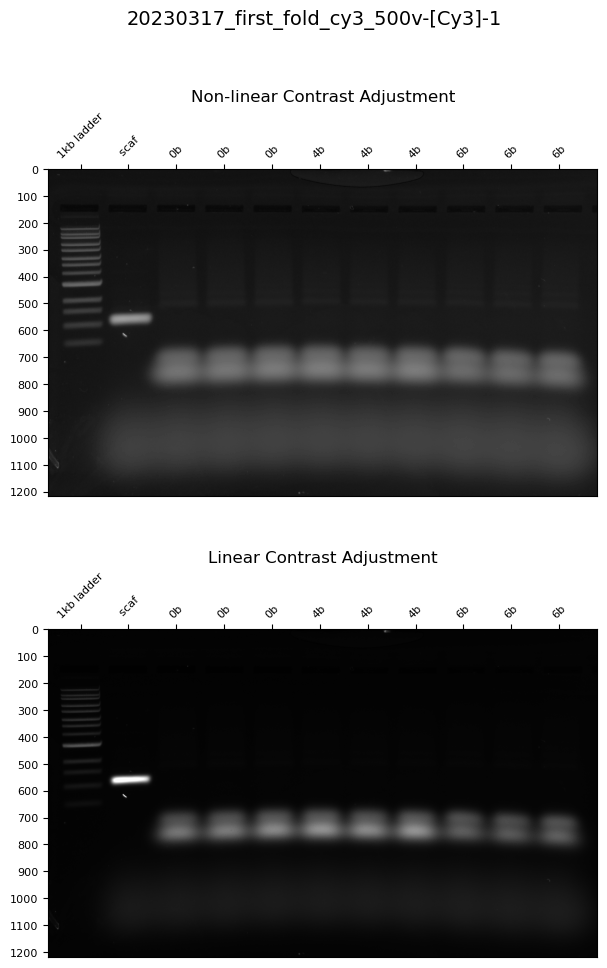

Used line width: 74 px, with a gel width of: 2043 px, and 11 xlabel positions
initial_guess: [0.0038256469015201444, 126, 1, 0.004144776120090829, 146, 1, 0.0045309192214602525, 160, 1, 0.004612029875721508, 186, 1, 0.004376884884056359, 207, 1, 0.0047411237713071005, 237, 1, 0.004087575758964076, 260, 1, 0.003147429539117714, 290, 1, 0.00823511701499563, 333, 1, 0.003297885465304199, 391, 1, 0.0024441632981934253, 430, 1, 0.002211024385544097, 483, 1, 0.0016095802092606084, 549, 1, 0, 0]
lower_bounds[0, 125, 0, 0, 145, 0, 0, 159, 0, 0, 185, 0, 0, 206, 0, 0, 236, 0, 0, 259, 0, 0, 289, 0, 0, 332, 0, 0, 390, 0, 0, 429, 0, 0, 482, 0, 0, 548, 0, 0, 0]
upper_bounds[inf, 127, inf, inf, 147, inf, inf, 161, inf, inf, 187, inf, inf, 208, inf, inf, 238, inf, inf, 261, inf, inf, 291, inf, inf, 334, inf, inf, 392, inf, inf, 431, inf, inf, 484, inf, inf, 550, inf, inf, inf]


,selected_lane_index,label,band_number,relative_area,Amplitude,Mean,Standard Deviation
0,0,1kb ladder,1,0.074,3.140e-03,126.103,2.561
1,0,1kb ladder,4,0.077,3.288e-03,146.113,3.415
2,0,1kb ladder,7,0.094,3.986e-03,159.000,2.812
3,0,1kb ladder,10,0.092,3.911e-03,185.000,3.537
4,0,1kb ladder,13,0.088,3.730e-03,206.000,3.534
5,0,1kb ladder,16,0.096,4.078e-03,236.419,3.860
6,0,1kb ladder,19,0.080,3.425e-03,259.285,3.923
7,0,1kb ladder,22,0.059,2.504e-03,289.432,4.309
8,0,1kb ladder,25,0.179,7.642e-03,332.000,5.128
9,0,1kb ladder,28,0.062,2.657e-03,390.733,5.729


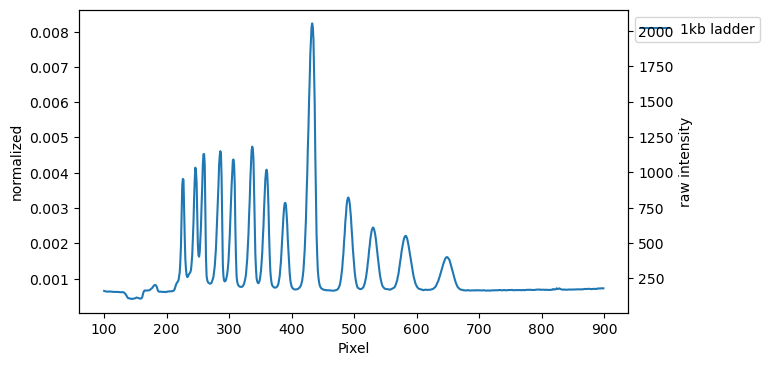

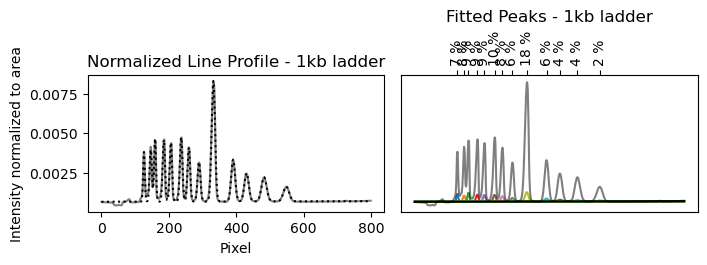

In [8]:
gel = AgaroseGel("./20230317_first_fold_cy3_500v-[Cy3]-1.tif", labels=['1kb ladder', ' scaf', '0b', '0b', '0b', '4b', '4b', '4b', '6b', '6b', '6b'])
gel.show_adjusted_images(x_label_pos=(120, 1900, 11))
#gel.show_line_profiles(select_lanes=[0,2,5],slice_line_profile_length=(400, 800))
gel.show_line_profiles(select_lanes=[0],slice_line_profile_length=(100, 900), fit="gaussian",
                       maxima_prominence=0.0005, maxima_threshold=0.001,
                       plot_fits=True)